In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix
%matplotlib inline

In [2]:
#load data file
data = pd.read_csv(r"C:\Users\Lt col Haider\OneDrive\IBA\semester 4\Foundations to Data Science\project\loan_data_set.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
data.shape

(614, 13)

# Data Cleaning

In [4]:
#Loan_ID is a unique variable so drop it
data =  data.drop(columns = ['Loan_ID'])

In [5]:
#re-label categorical variables
data.Loan_Status.replace({'Y': 0, 'N':1}, inplace=True)
data.Gender.replace({'Male':1, 'Female':0}, inplace=True)
data.Married.replace({'Yes': 1, 'No':0}, inplace=True)
data.Education.replace({'Graduate': 1, 'Not Graduate':0}, inplace=True)
data.Self_Employed.replace({'Yes': 1, 'No':0}, inplace=True)

In [6]:
#create dummy variables for 'Property_Area' and 'Dependents'
data = data.join(pd.get_dummies(data.Dependents, prefix='Dependents'))
data.drop(columns= ['Dependents'], inplace=True)
data = data.join(pd.get_dummies(data.Property_Area, prefix='Property_Area'))
data.drop(columns= ['Property_Area'], inplace=True)

In [7]:
data.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1.0,0.0,1,0.0,5849,0.0,NaN,360.0,1.0,0,1,0,0,0,0,0,1
1,1.0,1.0,1,0.0,4583,1508.0,128.0,360.0,1.0,1,0,1,0,0,1,0,0
2,1.0,1.0,1,1.0,3000,0.0,66.0,360.0,1.0,0,1,0,0,0,0,0,1
3,1.0,1.0,0,0.0,2583,2358.0,120.0,360.0,1.0,0,1,0,0,0,0,0,1
4,1.0,0.0,1,0.0,6000,0.0,141.0,360.0,1.0,0,1,0,0,0,0,0,1


In [8]:
#check for missing values 
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Credit_History,Self_Employed,LoanAmount,Loan_Amount_Term,Gender,Married,Dependents_1,Dependents_0,Loan_Status,Property_Area_Semiurban,Dependents_2,Dependents_3+,CoapplicantIncome,ApplicantIncome,Property_Area_Rural,Education,Property_Area_Urban
Total,50.000000,32.000000,22.000000,14.00000,13.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,8.143322,5.211726,3.583062,2.28013,2.117264,0.488599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Normalize data for effective KNN Imputation
#will manually normalize as NaN values present so preprocessing can't be used
def normalize(data):
    return (data - data.min()) * 1.0 / (data.max() - data.min())
data = data.apply(normalize)

In [10]:
#Apply KNN Imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=15)
df = imputer.fit_transform(data)

In [11]:
#convert array back to dataframe
data = pd.DataFrame(df)
#bring data back in original form
data.columns = ['Gender','Married','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount',
                'Loan_Amount_Term','Credit_History','Loan_Status','Dependents_0','Dependents_1','Dependents_2','Dependents_3+',
                'Property_Area_Rural','Property_Area_Semiurban','Property_Area_Urban']
data.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1.0,0.0,1.0,0.0,0.070489,0.000000,0.159672,0.74359,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,0.0,0.054830,0.036192,0.172214,0.74359,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.035250,0.000000,0.082489,0.74359,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.030093,0.056592,0.160637,0.74359,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.072356,0.000000,0.191027,0.74359,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
#check for missing values again
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Property_Area_Urban,Loan_Amount_Term,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area_Semiurban,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Gender
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#check outliers in dataset using Z-Score
from scipy import stats
z = np.abs(stats.zscore(data))
print(z)                            
threshold = 3
print(np.where(z > 3))

[[0.48155919 1.36975064 0.52836225 ... 0.64147818 0.7820157  1.42814704]
 [0.48155919 0.73281659 0.52836225 ... 1.55889948 0.7820157  0.70020801]
 [0.48155919 0.73281659 0.52836225 ... 0.64147818 0.7820157  1.42814704]
 ...
 [0.48155919 0.73281659 0.52836225 ... 0.64147818 0.7820157  1.42814704]
 [0.48155919 0.73281659 0.52836225 ... 0.64147818 0.7820157  1.42814704]
 [2.10907171 1.36975064 0.52836225 ... 0.64147818 1.2787467  0.70020801]]
(array([  7,   9,  14,  34,  61,  68,  68,  73,  74,  78,  79,  94, 109,
       126, 126, 130, 133, 135, 155, 155, 155, 171, 171, 171, 172, 177,
       177, 177, 183, 185, 202, 211, 213, 215, 242, 255, 257, 259, 262,
       267, 278, 295, 308, 313, 321, 324, 333, 333, 338, 340, 343, 352,
       359, 369, 376, 390, 391, 402, 409, 409, 417, 432, 442, 443, 461,
       466, 472, 481, 487, 495, 497, 506, 515, 522, 523, 525, 531, 539,
       546, 557, 561, 567, 574, 575, 581, 585, 592, 600, 600, 602, 604,
       610], dtype=int64), array([13,  5,  7, 13, 1

In [14]:
#remove outliers
data = data[(z < 3).all(axis=1)]
data.shape

(533, 17)

# Exploratory Data Analysis

In [15]:
data.describe()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
count,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.0,533.000000,533.000000,533.000000
mean,0.799500,0.630394,0.780488,0.132208,0.055329,0.034650,0.182060,0.719187,0.846404,0.307692,0.619137,0.174484,0.178236,0.0,0.290807,0.373358,0.335835
std,0.397906,0.482130,0.414305,0.331459,0.036816,0.039609,0.080011,0.107869,0.353320,0.461972,0.486055,0.379882,0.383071,0.0,0.454561,0.484150,0.472725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.358974,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.032220,0.000000,0.131693,0.743590,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.044119,0.031248,0.169320,0.743590,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.066172,0.054792,0.218524,0.743590,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.253766,0.215518,0.536903,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


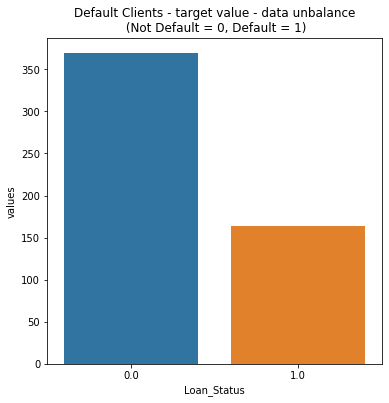

In [16]:
temp = data["Loan_Status"].value_counts()
df = pd.DataFrame({'Loan_Status': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Clients - target value - data unbalance\n (Not Default = 0, Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'Loan_Status', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

Data is imbalanced.

In [17]:
numerical = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
categorical = ['Credit_History','Gender','Married','Education','Self_Employed','Dependents_0','Dependents_1','Dependents_2',
               'Dependents_3+','Property_Area_Rural','Property_Area_Semiurban','Property_Area_Urban']

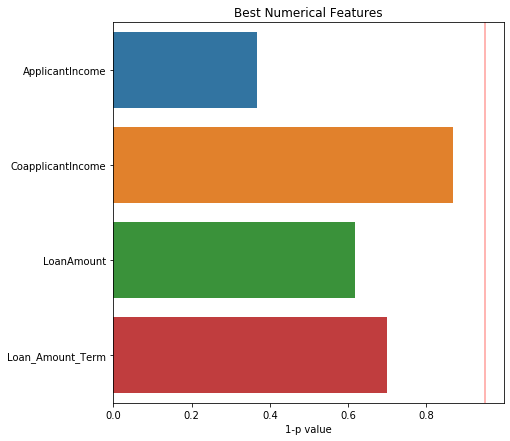

In [18]:
#T Test for numerical columns
p=[]
from scipy.stats import ttest_ind

for i in numerical:
    df1=data.groupby('Loan_Status').get_group(0)
    df2=data.groupby('Loan_Status').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    p.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=p, y=numerical)
plt.title('Best Numerical Features')
plt.axvline(x=(1-0.05),color='r')
plt.xlabel('1-p value')
plt.show()

'CoappliantIncome' has the greatest importance. None of them show statistical significance though.

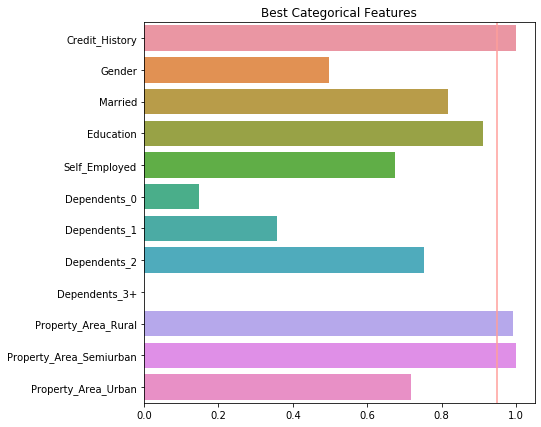

In [19]:
#Chi Square test for Categorical Columns
from scipy.stats import chi2_contingency
l=[]
for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(data['Loan_Status'],data[i]))[1]
    l.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1-0.05),color='r')
plt.show()

'Credit_History', 'Property_Area_Rural' and 'Property_Area_Semiurban' show statistical significance. 'Dependents_3+' has very low significance, so drop it.

In [20]:
data =  data.drop(columns = ['Dependents_3+'])

In [21]:
#drop target variable: 'Default'
features =  data.drop(columns = ['Loan_Status'])

In [22]:
#correlation analysis
corr_matrix = features.corr().abs()
corr_matrix

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Dependents_0,Dependents_1,Dependents_2,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
Gender,1.000000,0.371364,0.050837,0.015270,0.012556,0.202383,0.171739,0.106348,0.008722,0.151308,0.044517,0.147746,0.082559,0.121970,0.045531
Married,0.371364,1.000000,0.021116,0.019860,0.007458,0.259718,0.205034,0.120622,0.025103,0.329109,0.137251,0.275940,0.014676,0.007126,0.006813
Education,0.050837,0.021116,1.000000,0.010973,0.151525,0.019276,0.135597,0.090932,0.075710,0.041435,0.006991,0.037264,0.099567,0.062626,0.031602
Self_Employed,0.015270,0.019860,0.010973,1.000000,0.251736,0.040629,0.123804,0.052935,0.030584,0.095227,0.117008,0.004544,0.019643,0.001280,0.017577
ApplicantIncome,0.012556,0.007458,0.151525,0.251736,1.000000,0.228698,0.441993,0.056216,0.015630,0.081156,0.054636,0.034840,0.001924,0.026774,0.029272
CoapplicantIncome,0.202383,0.259718,0.019276,0.040629,0.228698,1.000000,0.314743,0.089052,0.003216,0.010898,0.011022,0.013498,0.090991,0.017835,0.069229
LoanAmount,0.171739,0.205034,0.135597,0.123804,0.441993,0.314743,1.000000,0.022247,0.012941,0.128236,0.076126,0.090088,0.061388,0.008507,0.050316
Loan_Amount_Term,0.106348,0.120622,0.090932,0.052935,0.056216,0.089052,0.022247,1.000000,0.022029,0.088680,0.117020,0.005350,0.022133,0.062503,0.085296
Credit_History,0.008722,0.025103,0.075710,0.030584,0.015630,0.003216,0.012941,0.022029,1.000000,0.042542,0.023092,0.006365,0.045168,0.061890,0.019953
Dependents_0,0.151308,0.329109,0.041435,0.095227,0.081156,0.010898,0.128236,0.088680,0.042542,1.000000,0.586171,0.593791,0.093872,0.001663,0.088561


In [23]:
#Feature Selection 

#Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
#Drop highly correlated attributes
data = data.drop(data[to_drop], axis=1)
data.shape

(533, 16)

No highly correlated attributes found.

In [24]:
pd.crosstab(data.Married, data.Loan_Status)

Loan_Status,0.0,1.0
Married,,
0.000000,124,72
0.400000,1,0
0.666667,1,0
0.933333,1,0
1.000000,242,92


Those not married have a higher percentage on defaulting.

In [25]:
pd.crosstab(data.Education, data.Loan_Status)

Loan_Status,0.0,1.0
Education,,
0.0,73,44
1.0,296,120


Graduates are more in number and thus are more in number for both default and not defaut. Not Graduates have a higher percentage of defaulting which makes sense. 

In [26]:
pd.crosstab(data.Dependents_0, data.Loan_Status)

Loan_Status,0.0,1.0
Dependents_0,,
0.0,142,61
1.0,227,103


Percentage of default for those with no dependents and those with dependents is almost the same.

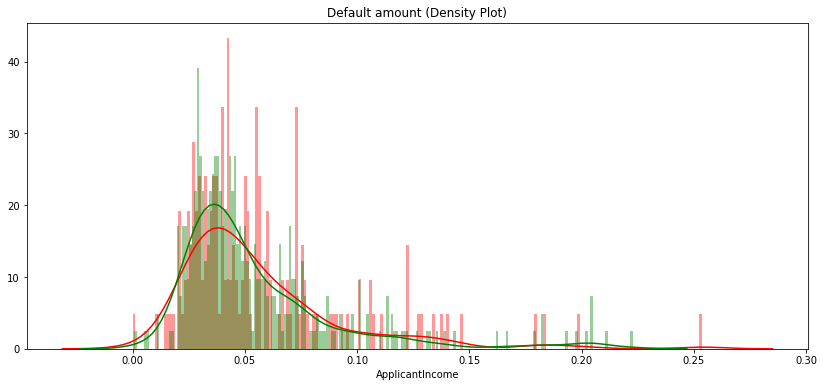

In [27]:
class_0 = data.loc[data['Loan_Status'] == 0]["ApplicantIncome"]
class_1 = data.loc[data['Loan_Status'] == 1]["ApplicantIncome"]
plt.figure(figsize = (14,6))
plt.title('Default amount (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

Data is right skewed. Those with less Applicant Incomes have higher defaulting tendency. The highest default is for value 0.04.

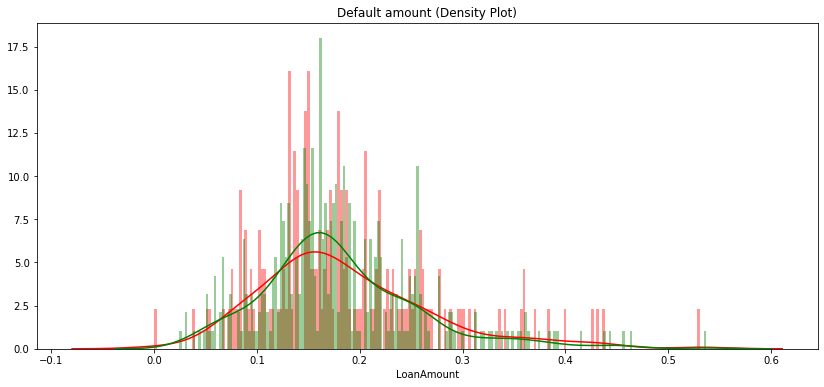

In [28]:
class_0 = data.loc[data['Loan_Status'] == 0]["LoanAmount"]
class_1 = data.loc[data['Loan_Status'] == 1]["LoanAmount"]
plt.figure(figsize = (14,6))
plt.title('Default amount (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

Data has a normal distribution.

# Pre-Processing

In [29]:
#Split test and train data
x = data.drop(columns = 'Loan_Status')
y = data['Loan_Status']

#will train on 70% of the data, test on the remaining 30%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=50)

In [30]:
y.value_counts(normalize=True)

0.0    0.692308
1.0    0.307692
Name: Loan_Status, dtype: float64

Majority class (not default) has 69% samples. Minority class (default) has 31% samples. Data is imbalanced. Thus, will apply SMOTE.

In [31]:
from imblearn.over_sampling import SMOTE
#so as not to lose any important information, apply SMOTE (Synthetic Minority Oversampling Technique) to fix class imbalance
sm = SMOTE(random_state=10)
x_smote, y_smote = sm.fit_sample(x_train, y_train)

# Modeling

# 1. Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 1, 10]}

lr = LogisticRegression(penalty='l2', class_weight='balanced')
lr = GridSearchCV(estimator = lr, param_grid = param_grid, n_jobs = -1)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[99 14]
 [14 33]]
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       113
         1.0       0.70      0.70      0.70        47

    accuracy                           0.82       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.82      0.82      0.82       160



Text(0.5, 0, 'False Positive Rate')

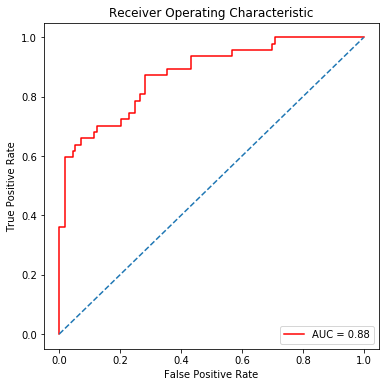

In [33]:
from sklearn.metrics import roc_curve, auc
y_prob = lr.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [34]:
lr.fit(x_smote, y_smote)
y_pred = lr.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[98 15]
 [15 32]]
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       113
         1.0       0.68      0.68      0.68        47

    accuracy                           0.81       160
   macro avg       0.77      0.77      0.77       160
weighted avg       0.81      0.81      0.81       160



Best result on original data = 0.82, AUC = 0.88

# 2. Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier

# Decision tree with depth = 2
dt2 = tree.DecisionTreeClassifier(random_state=42, max_depth=2)
dt2.fit(x_train, y_train)
dt2_score_train = dt2.score(x_train, y_train)
print("Training score: ",dt2_score_train)
dt2_score_test = dt2.score(x_test, y_test)
print("Testing score: ",dt2_score_test)

Training score:  0.8257372654155496
Testing score:  0.85


In [36]:
# Decision tree with depth = 3
dt3 = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
dt3.fit(x_train, y_train)
dt3_score_train = dt3.score(x_train, y_train)
print("Training score: ",dt3_score_train)
dt3_score_test = dt3.score(x_test, y_test)
print("Testing score: ",dt3_score_test)

Training score:  0.8284182305630027
Testing score:  0.84375


In [37]:
# Decision tree with depth = 4
dt4 = tree.DecisionTreeClassifier(random_state=42, max_depth=4)
dt4.fit(x_train, y_train)
dt4_score_train = dt4.score(x_train, y_train)
print("Training score: ",dt4_score_train)
dt4_score_test = dt4.score(x_test, y_test)
print("Testing score: ",dt4_score_test)

Training score:  0.8445040214477212
Testing score:  0.84375


In [38]:
# Decision tree: To the full depth
dt1 = tree.DecisionTreeClassifier()
dt1.fit(x_train, y_train)
dt1_score_train = dt1.score(x_train, y_train)
print("Training score: ", dt1_score_train)
dt1_score_test = dt1.score(x_test, y_test)
print("Testing score: ", dt1_score_test)

Training score:  1.0
Testing score:  0.7625


In [39]:
#Compare Training and Testing scores for various tree depths used
print('{:10} {:20} {:20}'.format('depth', 'Training score','Testing score'))
print('{:10} {:20} {:20}'.format('-----', '--------------','-------------'))
print('{:1} {:>25} {:>20}'.format(2, dt2_score_train, dt2_score_test))
print('{:1} {:>25} {:>20}'.format(3, dt3_score_train, dt3_score_test))
print('{:1} {:>25} {:>20}'.format(4, dt4_score_train, dt4_score_test))
print('{:1} {:>23} {:>20}'.format("max", dt1_score_train, dt1_score_test))

depth      Training score       Testing score       
-----      --------------       -------------       
2        0.8257372654155496                 0.85
3        0.8284182305630027              0.84375
4        0.8445040214477212              0.84375
max                     1.0               0.7625


Highest testing accuracy reached at depth 2. At this depth, training accuracy is good too so will go with this.

In [40]:
y_pred = dt2.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[109   4]
 [ 20  27]]
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90       113
         1.0       0.87      0.57      0.69        47

    accuracy                           0.85       160
   macro avg       0.86      0.77      0.80       160
weighted avg       0.85      0.85      0.84       160



Text(0.5, 0, 'False Positive Rate')

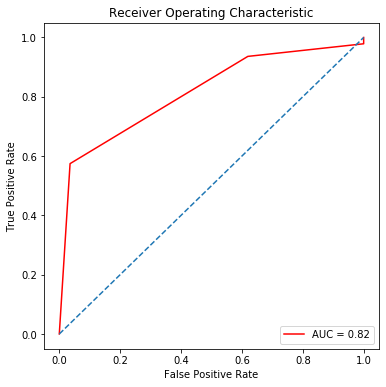

In [41]:
y_prob = dt2.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [42]:
dt2.fit(x_smote, y_smote)
dt2_score_train = dt2.score(x_smote, y_smote)
print("Training score: ",dt2_score_train)
dt2_score_test = dt2.score(x_test, y_test)
print("Testing score: ",dt2_score_test)

y_pred = dt2.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training score:  0.755859375
Testing score:  0.85
[[109   4]
 [ 20  27]]
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90       113
         1.0       0.87      0.57      0.69        47

    accuracy                           0.85       160
   macro avg       0.86      0.77      0.80       160
weighted avg       0.85      0.85      0.84       160



Best result on original data = 0.85, AUC = 0.82

# 3. Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(n_estimators=100)

In [44]:
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[108   5]
 [ 14  33]]
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92       113
         1.0       0.87      0.70      0.78        47

    accuracy                           0.88       160
   macro avg       0.88      0.83      0.85       160
weighted avg       0.88      0.88      0.88       160



Text(0.5, 0, 'False Positive Rate')

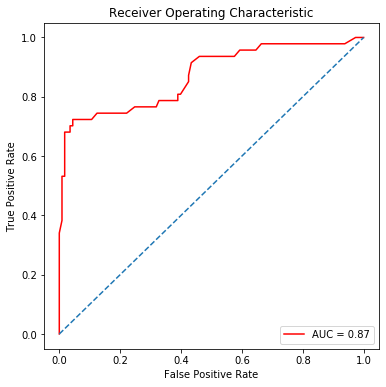

In [45]:
y_prob = rf.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [46]:
rf.fit(x_smote, y_smote)
y_pred = rf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[102  11]
 [ 14  33]]
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       113
         1.0       0.75      0.70      0.73        47

    accuracy                           0.84       160
   macro avg       0.81      0.80      0.81       160
weighted avg       0.84      0.84      0.84       160



Best result on original data = 0.86, AUC = 0.86

# 4. Support Vector Machine (SVM)

In [47]:
from sklearn import svm
from sklearn import metrics

In [48]:
#Radial Basis Function Kernel with low gamma 0.01

clf = svm.SVC(kernel='rbf', random_state=0, gamma=.01, C=1) 

#Train the model using the training sets
clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

Accuracy: 0.70625
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83       113
         1.0       0.00      0.00      0.00        47

    accuracy                           0.71       160
   macro avg       0.35      0.50      0.41       160
weighted avg       0.50      0.71      0.58       160



C:\Users\Lt col Haider\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
#Radial Basis Fnction Kernel with penalty parameter c = 1000.
#classifier starts to become very intolerant to misclassified data points and thus the decision boundary becomes less biased and has more variance (i.e. more dependent on the individual data points)
clf = svm.SVC(kernel='rbf', random_state=0, gamma=.01, C=1000) 

#Train the model using the training sets
clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

#takes too much training time.
from sklearn import metrics

# model accuracy:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8625
[[111   2]
 [ 20  27]]
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91       113
         1.0       0.93      0.57      0.71        47

    accuracy                           0.86       160
   macro avg       0.89      0.78      0.81       160
weighted avg       0.87      0.86      0.85       160



Text(0.5, 0, 'False Positive Rate')

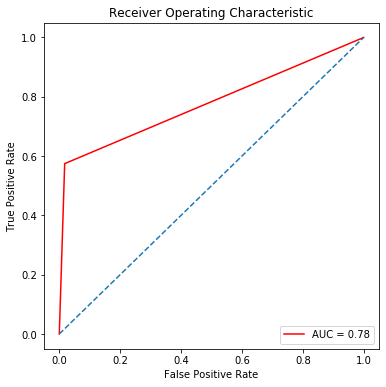

In [50]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [51]:
#Radial Basis Fnction Kernel with penalty parameter c = 1000.
#classifier starts to become very intolerant to misclassified data points and thus the decision boundary becomes less biased and has more variance (i.e. more dependent on the individual data points)
clf = svm.SVC(kernel='rbf', random_state=0, gamma=.01, C=1000) 

#Train the model using the training sets
clf.fit(x_smote, y_smote)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

#takes too much training time.
from sklearn import metrics

# model accuracy:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.83125
[[103  10]
 [ 17  30]]
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88       113
         1.0       0.75      0.64      0.69        47

    accuracy                           0.83       160
   macro avg       0.80      0.77      0.79       160
weighted avg       0.83      0.83      0.83       160



Best result on original data = 0.86, AUC = 0.78

# 5. Naive Bayes

In [52]:
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB()
naive.fit(x_train, y_train)
    
# Make predictions and evalute
y_pred = naive.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))    
print(classification_report(y_test, y_pred))

Accuracy: 0.8625
[[111   2]
 [ 20  27]]
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91       113
         1.0       0.93      0.57      0.71        47

    accuracy                           0.86       160
   macro avg       0.89      0.78      0.81       160
weighted avg       0.87      0.86      0.85       160



Text(0.5, 0, 'False Positive Rate')

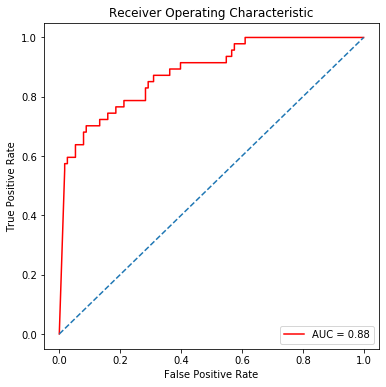

In [53]:
y_prob = naive.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [54]:
naive.fit(x_smote, y_smote)
    
# Make predictions and evalute
y_pred = naive.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))    
print(classification_report(y_test, y_pred))

Accuracy: 0.8375
[[106   7]
 [ 19  28]]
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89       113
         1.0       0.80      0.60      0.68        47

    accuracy                           0.84       160
   macro avg       0.82      0.77      0.79       160
weighted avg       0.83      0.84      0.83       160



Best result on original data = 0.86, AUC = 0.88

# 6. XGBoost Classifier

In [55]:
from xgboost import XGBClassifier

model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=5)

In [56]:
model.fit(x_train, y_train)
    
# Make predictions and evalute
y_pred = model.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) 
print(classification_report(y_test, y_pred))

Accuracy: 0.85625
[[109   4]
 [ 19  28]]
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90       113
         1.0       0.88      0.60      0.71        47

    accuracy                           0.86       160
   macro avg       0.86      0.78      0.81       160
weighted avg       0.86      0.86      0.85       160



Text(0.5, 0, 'False Positive Rate')

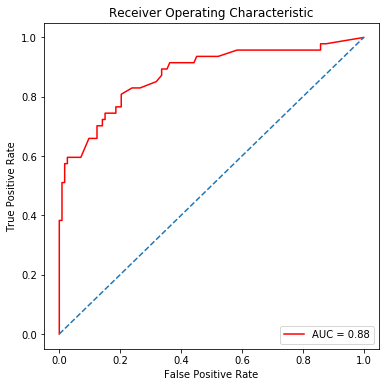

In [57]:
y_prob = model.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [58]:
model.fit(x_smote, y_smote)
    
# Make predictions and evalute
y_pred = model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) 
print(classification_report(y_test, y_pred))

Accuracy: 0.86875
[[109   4]
 [ 17  30]]
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       113
         1.0       0.88      0.64      0.74        47

    accuracy                           0.87       160
   macro avg       0.87      0.80      0.83       160
weighted avg       0.87      0.87      0.86       160



Text(0.5, 0, 'False Positive Rate')

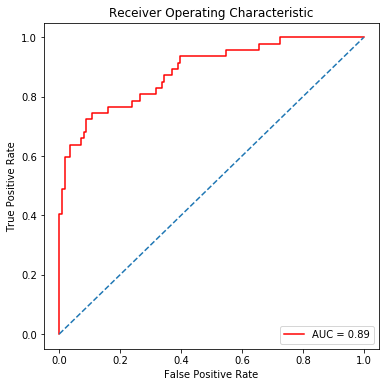

In [59]:
y_prob = model.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Best result on original data = 0.87, AUC = 0.89

In [ ]:
Best Accuracy = 0.87, XGB | Best AUC = 0.89 XGB | Best Model = XGBoost Classifier